In [21]:
# Imports
import pandas as pd

from dslabs_functions import (
    get_variable_types,)

In [22]:
# Read
filename = 'class_pos_covid_derived.csv'
file_tag = 'covid_fig_'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


variable_types = get_variable_types(data)
symbolic: list[str] = variable_types["symbolic"]
data[symbolic] = data[symbolic].apply(lambda x: x.astype("category"))
variables_types: dict[str, list] = get_variable_types(data)
# TODO why is Sex not in categorical?


In [23]:
state_values =  { 
    "Alabama": [32.318230, -86.902298],
    "Alaska": [66.160507, -153.369141],
    "Arizona": [34.048927, -111.093735],
    "Arkansas": [34.799999, -92.199997],
    "California": [36.778259, -119.417931],
    "Colorado": [39.113014, -105.358887],
    "Connecticut": [41.599998, -72.699997],
    "Delaware": [39.0, -75.5],
    "District of Columbia": [38.9072, -77.0369],
    "Florida": [27.994402, -81.760254],
    "Georgia": [33.247875, -83.441162],
    "Guam": [13.444304, 144.793732],
    "Hawaii": [19.741755, -155.844437],
    "Idaho": [44.068203, -114.742043],
    "Illinois": [40.0, -89.0],      
    "Indiana": [40.273502, -86.126976],
    "Iowa": [42.032974, -93.581543],
    "Kansas": [38.5, -98.0],
    "Kentucky": [37.839333, -84.270020],
    "Louisiana": [30.391830, -92.329102],
    "Maine": [45.367584, -68.972168],
    "Maryland": [39.045753, -76.641273],
    "Massachusetts": [42.407211, -71.382439],
    "Michigan": [44.182205, -84.506836],
    "Minnesota": [46.392410, -94.636230],
    "Mississippi": [33.0, -90.0],
    "Missouri": [38.573936, -92.603760],
    "Montana": [46.965260, -109.533691],
    "Nebraska": [41.500000, -100.000000],
    "Nevada": [39.876019, -117.224121],
    "New Hampshire": [44.0, -71.5],
    "New Jersey": [39.833851, -74.871826],
    "New Mexico": [34.307144, -106.018066],
    "New York": [43.000000, -75.000000],
    "North Carolina": [35.782169, -80.793457],
    "North Dakota": [47.650589, -100.437012],
    "Ohio": [40.367474, -82.996216],
    "Oklahoma": [36.084621, -96.921387],
    "Oregon": [44.000000, -120.500000],
    "Pennsylvania": [41.203323, -77.194527],
    "Puerto Rico": [18.2208, -66.5901],
    "Rhode Island": [41.700001, -71.500000],
    "South Carolina": [33.836082, -81.163727],
    "South Dakota": [44.500000, -100.000000],
    "Tennessee": [35.860119, -86.660156],
    "Texas": [31.000000, -100.000000],
    "Utah": [39.419220, -111.950684],
    "Vermont": [44.000000, -72.699997],
    "Virginia": [37.926868, -78.024902],
    "Virgin Islands": [18.3358, -64.8963],
    "Washington": [47.751076, -120.740135],
    "West Virginia": [39.000000, -80.500000],
    "Wisconsin": [44.500000, -89.500000],
    "Wyoming": [43.075970, -107.290283]
}

# create two new columns in the dataframe with the latitude and longitude values
data["Latitude"] = data["State"].apply(lambda x: state_values[x][0])
data["Longitude"] = data["State"].apply(lambda x: state_values[x][1])
min_long = abs(data["Longitude"].min())
data["Longitude"] = data["Longitude"].apply(lambda x: x + min_long) # to not have negative values for the models

data.drop(['State'], axis=1, inplace=True)
# 0.2s

In [24]:
# GeneralHealth ['Very good', 'Good', 'Excellent', 'Poor', 'Fair']
general_values = {
    "Excellent": 4,
    "Very good": 3,
    "Good": 2,
    "Fair": 1,
    "Poor": 0,
}

# LastCheckupTime ['Within past year (anytime less than 12 months ago)', 'Within past 2 years (1 year but less than 2 years ago)', '5 or more years ago', 'Within past 5 years (2 years but less than 5 years ago)']
last_values = {
    "Within past year (anytime less than 12 months ago)": 0,
    "Within past 2 years (1 year but less than 2 years ago)": 1,
    "Within past 5 years (2 years but less than 5 years ago)": 2,
    "5 or more years ago": 3,
}

# RemovedTeeth ['None of them', '1 to 5', '6 or more, but not all', 'All']
teeth_values = {
    "None of them": 0,
    "1 to 5": 1,
    "6 or more, but not all": 2,
    "All": 3,
}

# HadDiabetes ['No',  'Yes',  'Yes, but only during pregnancy (female)', 'No, pre-diabetes or borderline diabetes']
diabetes_values = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 1,
    'Yes, but only during pregnancy (female)': 2,
    'Yes': 3,
}

# SmokerStatus ['Former smoker', 'Never smoked', 'Current smoker - now smokes every day', 'Current smoker - now smokes some days']
smoker_values = {
    'Never smoked': 0,
    'Former smoker': 1,
    'Current smoker - now smokes some days': 2,
    'Current smoker - now smokes every day': 3,
}

# ECigaretteUsage ['Never used e-cigarettes in my entire life', 'Use them some days', 'Not at all (right now)', 'Use them every day']
ecig_values = {
    'Never used e-cigarettes in my entire life': 0,
    'Not at all (right now)': 1,
    'Use them some days': 2,
    'Use them every day': 3,
}

# TODO confirm this
# RaceEthnicityCategory ['White only, Non-Hispanic', 'Black only, Non-Hispanic', 'Multiracial, Non-Hispanic', 'Other race only, Non-Hispanic', 'Hispanic']
race_values = {
    'White only, Non-Hispanic': 0,
    'Black only, Non-Hispanic': 1,
    'Multiracial, Non-Hispanic': 2,
    'Other race only, Non-Hispanic': 3,
    'Hispanic': 4,
}

# "AgeCategory ['Age 65 to 69', 'Age 70 to 74', 'Age 80 or older', 'Age 50 to 54', 'Age 75 to 79', 'Age 60 to 64', 'Age 55 to 59', 'Age 45 to 49', 'Age 40 to 44', 'Age 25 to 29', 'Age 30 to 34', 'Age 18 to 24', 'Age 35 to 39']"
age_values = {
    'Age 18 to 24': 0,
    'Age 25 to 29': 1,
    'Age 30 to 34': 2,
    'Age 35 to 39': 3,
    'Age 40 to 44': 4,
    'Age 45 to 49': 5,
    'Age 50 to 54': 6,
    'Age 55 to 59': 7,
    'Age 60 to 64': 8,
    'Age 65 to 69': 9,
    'Age 70 to 74': 10,
    'Age 75 to 79': 11,
    'Age 80 or older': 12,
}

# TODO confirm if this is the best way to do this
# "TetanusLast10Tdap ['Yes, received Tdap', 'Yes, received tetanus shot but not sure what type', 'No, did not receive any tetanus shot in the past 10 years', 'Yes, received tetanus shot, but not Tdap']"
tetanus_values = {
    'No, did not receive any tetanus shot in the past 10 years': 0,
    'Yes, received tetanus shot, but not Tdap': 1,
    'Yes, received tetanus shot but not sure what type': 2,
    'Yes, received Tdap': 3,
}


encoding: dict[str, dict[str, int]] = {
    "GeneralHealth": general_values,
    "LastCheckupTime": last_values,
    "RemovedTeeth": teeth_values,
    "HadDiabetes": diabetes_values,
    "SmokerStatus": smoker_values,
    "ECigaretteUsage": ecig_values,
    "RaceEthnicityCategory": race_values,
    "AgeCategory": age_values,
    "TetanusLast10Tdap": tetanus_values,
    # "Region": region_values, TODO have to confirm this
    # "AgeGroup": age_group_values,
}

data = data.replace(encoding, inplace=False)
data.head()

# drop age group and region
data.drop(['AgeGroup', 'Region'], axis=1, inplace=True)

In [25]:
binaries = variable_types["binary"]

# make all the binary variables fine for classification
for binary in binaries:
    data[binary] = data[binary].apply(lambda x: 1 if x == "Yes" else x)
    data[binary] = data[binary].apply(lambda x: 0 if x == "No" else x)
    data[binary] = data[binary].apply(lambda x: 0 if x == "Female" else x)
    data[binary] = data[binary].apply(lambda x: 1 if x == "Male" else x)


In [26]:
# save data to csv
data.to_csv('class_pos_covid_derived_prepared.csv', index=False)

### Missing Values
#### Drop

In [ ]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart,  mvi_by_filling, evaluate_approach

# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [32]:
print(data.shape)

df: DataFrame = data.dropna(how="any", inplace=False)
print(df.shape)


(380932, 41)
(237630, 41)


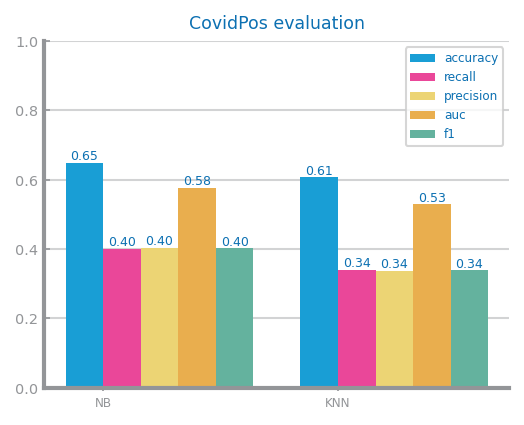

In [27]:
# dropna
data.dropna(inplace=True)
target = "CovidPos"
file_tag = "CovidPos"
# use train test split to create the train and test sets using data variable
train: DataFrame = data.sample(frac=0.7, random_state=1)
test: DataFrame = data.drop(train.index)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()
# 3m 30s

#### Filling with dummy value (usually: NaN, -1 or 0 for numeric, 'NA' for symbolic and False for boolean)

In [ ]:
# read class_pos_covid_derived_prepared
filename = 'class_pos_covid_derived_prepared.csv'
data = pd.read_csv(filename, sep=',', decimal='.', na_values='')


In [33]:
# TODO

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,3.0,0.0,0.0,0.00000,8.0,0.692646,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.33916,6.0,0.692646,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.00000,7.0,0.692646,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,2.0,0.0,0.00000,9.0,0.692646,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.00000,7.0,0.692646,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,3.0,0.0,0.0,0.00000,7.0,0.692646,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.0,0.0,0.0,0.00000,8.0,0.692646,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
7,2.0,0.0,0.0,0.00000,6.0,0.692646,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,2.0,1.0,0.0,0.00000,7.0,0.692646,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
9,1.0,8.0,9.0,0.00000,8.0,0.692646,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


#### Filling with mean, median, most_frequent value